Get the ratio of number of stars in RV over Gaia

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord

# get data from fits file
data_g = Table.read("gaia_data_with_straight_cutoff.fits")
data_rv = Table.read("gaia_rv_with_straight_cutoff.fits")

# get rid of stars with negative distance
mask_g = 1/data_g["parallax"]>0
data_g = data_g[mask_g]
mask_rv = 1/data_rv["parallax"]>0
data_rv = data_rv[mask_rv]

# get coordinates of both gaia and rv
ra_g = data_g['ra'] #degree
dec_g = data_g['dec'] #degree
distance_g = 1/data_g["parallax"] # in kpc
parallax_g = data_g["parallax"]

ra_rv = data_rv['ra'] #degree
dec_rv = data_rv['dec'] #degree
distance_rv = 1/data_rv["parallax"] # in kpc
parallax_rv = data_rv["parallax"]

# convert ra and dec to galactic coordinate
galactic_g = SkyCoord(ra_g, dec_g, unit="deg", frame="icrs").galactic
l_g = galactic_g.l.degree
b_g = galactic_g.b.degree

galactic_rv = SkyCoord(ra_rv, dec_rv, unit="deg", frame="icrs").galactic
l_rv = galactic_rv.l.degree
b_rv = galactic_rv.b.degree

#set variables for histogram
l_pixel = 1 # degree
b_pixel = 1 # degree
l_min = min(np.min(l_g), np.min(l_rv))
b_min = min(np.min(b_g), np.min(b_rv))
l_max = max(np.max(l_g), np.max(l_rv))
b_max = max(np.max(b_g), np.max(b_rv))
bin_l = (l_max - l_min)/l_pixel
bin_b = (b_max - b_min)/b_pixel

c:\users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
c:\users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:49: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
c:\users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


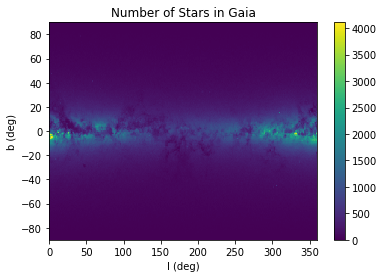

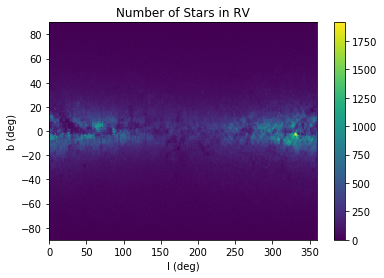

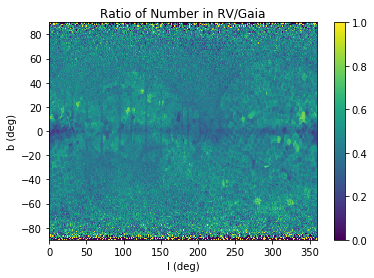

In [43]:
# get 2d histogram for gaia
plt.figure(1)
histogram_g, xedges, yedges, graph = plt.hist2d(l_g, b_g, 
                                                bins = (bin_l, bin_b),
                                                range = [[l_min, l_max],
                                                         [b_min, b_max]])
plt.colorbar()
plt.xlabel('l (deg)')
plt.ylabel('b (deg)')
plt.title("Number of Stars in Gaia")
plt.savefig("Number of Stars in Gaia.png")

# get 2d histogram for rv
plt.figure(2)
histogram_rv, xedges, yedges, graph = plt.hist2d(l_rv, b_rv, 
                                                bins = (bin_l, bin_b),
                                                range = [[l_min, l_max],
                                                         [b_min, b_max]])
plt.colorbar()
plt.xlabel('l (deg)')
plt.ylabel('b (deg)')
plt.title("Number of Stars in RV")
plt.savefig("Number of Stars in RV.png")

# define number of stars as a function of l and b
def number(l, b, histogram):
    l_index = ((l-l_min)/l_pixel).astype(int)-1
    b_index = ((b-b_min)/b_pixel).astype(int)-1
    if np.ndim(l) == 1:
        result = []
        for i in range(np.size(l_index)):
            result.append(histogram[l_index[i]][b_index[i]])
        return np.array(result)
    elif np.ndim(l) == 2:
        result = []
        for i in range(np.shape(l_index)[0]):
            row = []
            for j in range(np.shape(l_index)[1]):
                row.append(histogram[l_index[i][j]][b_index[i][j]])
            result.append(row)
        return np.array(result)

# define the ratio of number density as a function of l and b
def ratio(l, b):
    return number(l, b, histogram_rv)/number(l, b, histogram_g)

# compute an array of ratio and plot
l_linspace = np.linspace(l_min, l_max, bin_l)
b_linspace = np.linspace(b_min, b_max, bin_b)
l_v, b_v = np.meshgrid(l_linspace, b_linspace)
z = ratio(l_v, b_v)
# change nan to zero
z = np.nan_to_num(z)
plt.figure(3)
plt.pcolor(l_v, b_v, z)
plt.colorbar()
plt.xlabel('l (deg)')
plt.ylabel('b (deg)')
plt.title("Ratio of Number in RV/Gaia")
plt.savefig("Ratio of Number in RV Gaia.png")

Plot galactic plane over selection ratio

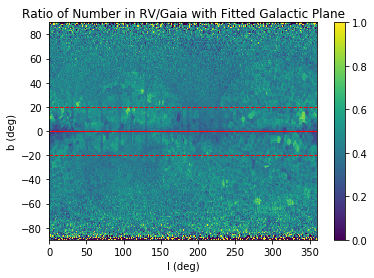

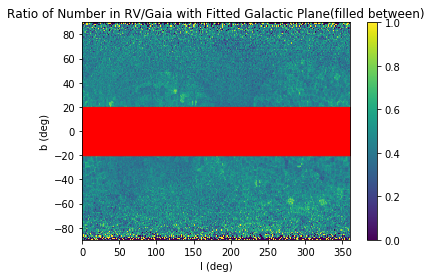

In [44]:
l_plane = np.linspace(0.,360.,1000)
b_plane = np.zeros(np.size(l_plane))

plt.figure(4)
plt.pcolor(l_v, b_v, z)
plt.plot(l_plane, b_plane, c = "red", linewidth = 1)
plt.plot(l_plane, b_plane+20., c = "red", linestyle = '--', linewidth = 1)
plt.plot(l_plane, b_plane-20.,c = "red", linestyle = '--', linewidth = 1)
plt.colorbar()
plt.xlim(0.,360.)
plt.xlabel('l (deg)')
plt.ylabel('b (deg)')
plt.title("Ratio of Number in RV/Gaia with Fitted Galactic Plane")
plt.savefig("Ratio of Number in RV Gaia with Fitted Galactic Plane.png")

plt.figure(5)
plt.pcolor(l_v, b_v, z)
plt.fill_between(l_plane, b_plane-20., b_plane+20., color= "red")
plt.colorbar()
plt.xlim(0,360)
plt.xlabel('l (deg)')
plt.ylabel('b (deg)')
plt.title("Ratio of Number in RV/Gaia with Fitted Galactic Plane(filled between)")
plt.savefig("Ratio of Number in RV Gaia with Fitted Galactic Plane(filled between).png")

Algorithm for the piece-wise seleciton function. The two versions of parallax selections are not implemented and what is shown below is a test of the algorithm of piece-wise selection.

In [45]:
def selection(parallax, l, b):
    mask = np.abs(b) < 20.
    out = np.empty(np.shape(b)[0])
    out[mask] = selection_galactic_plane(parallax[mask])
    out[~mask] = selection_elsewhere(parallax[~mask])
    return out

def selection_galactic_plane(parallax):
    return np.full(np.size(parallax), True)

def selection_elsewhere(parallax):
    return np.full(np.size(parallax), False)

In [46]:
rand = np.random.uniform(size = (1000,3), low = (0,0.,-90), high = (1,360.,90))
filtered = selection(*rand.T)
filtered = filtered.astype(bool)

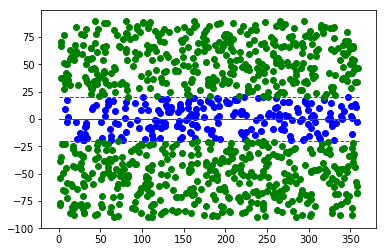

In [47]:
plt.figure()
plt.scatter(rand[filtered][:,1], rand[filtered][:,2], color = "blue")
plt.plot(l_plane, b_plane, c = "red", linewidth = 1)
plt.plot(l_plane, b_plane+20., c = "red", linestyle = '--', linewidth = 1)
plt.plot(l_plane, b_plane-20.,c = "red", linestyle = '--', linewidth = 1)
plt.scatter(rand[~filtered][:,1], rand[~filtered][:,2], color = "green")

Divide all gaia data into galactic plane and elsewhere

In [48]:
g_galactic_mask = np.abs(b_g) < 20.
parallax_g_galactic = parallax_g[g_galactic_mask]
parallax_g_elsewhere = parallax_g[~g_galactic_mask]

rv_galactic_mask = np.abs(b_rv) < 20.
parallax_rv_galactic = parallax_rv[rv_galactic_mask]
parallax_rv_elsewhere = parallax_rv[~rv_galactic_mask]

Galactic plane parallax selection

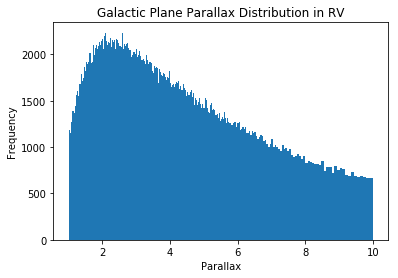

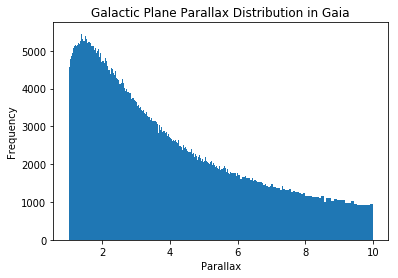

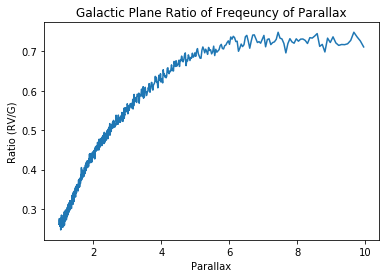

In [53]:
#set up min and max
parallax_min = 1
parallax_max = 10
#set up a list of even bins of 0.001 kpc in distance space, convert to uneven
#parralax bins
distance_pixel = 0.001
bins = np.flip(1/np.arange(1/parallax_max,1/parallax_min + distance_pixel, distance_pixel), axis =0)

#plot rv paralax distribution
plt.figure()
hist_parallax_rv_galactic, edges_rv, patches_rv = plt.hist(
    parallax_rv_galactic, range = (parallax_min, parallax_max), bins = bins)
plt.xlabel('Parallax')
plt.ylabel('Frequency')
plt.title("Galactic Plane Parallax Distribution in RV")
plt.savefig("Galactic Plane Parallax Distribution in RV.png")

#plot gaia paralax distribution
plt.figure()
hist_parallax_g_galactic, edges_g, patches_g = plt.hist(
        parallax_g_galactic, range = (parallax_min, parallax_max), bins = bins)
plt.xlabel('Parallax')
plt.ylabel('Frequency')
plt.title("Galactic Plane Parallax Distribution in Gaia")
plt.savefig("Galactic Plane Parallax Distribution in Gaia.png")

#plot ratio
plt.figure()
bins_centralized = bins[:-1] + (bins[1:] - bins[:-1])/2
ratio_galactic = hist_parallax_rv_galactic/hist_parallax_g_galactic
plt.plot(bins_centralized, ratio_galactic)
plt.xlabel('Parallax')
plt.ylabel('Ratio (RV/G)')
plt.title("Galactic Plane Ratio of Freqeuncy of Parallax")
plt.savefig("Galactic Plane Ratio of Freqeuncy of Parallax.png")

Elsewhere parallax selection

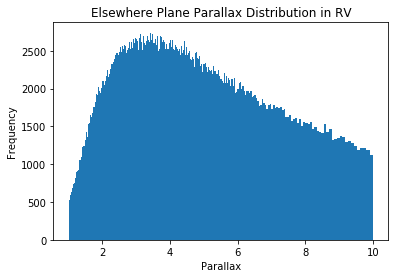

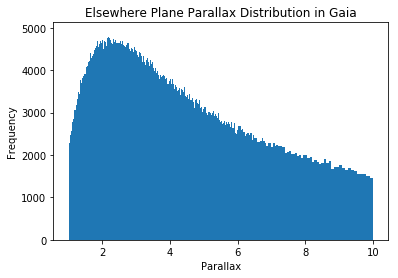

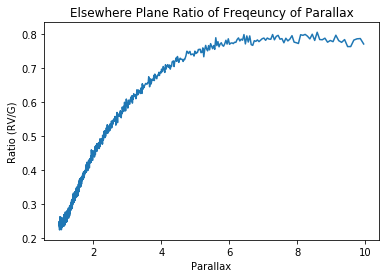

In [55]:
#set up min and max
parallax_min = 1
parallax_max = 10
#set up a list of even bins of 0.001 kpc in distance space, convert to uneven
#parralax bins
distance_pixel = 0.001
bins = np.flip(1/np.arange(1/parallax_max,1/parallax_min + distance_pixel, distance_pixel), axis =0)

#plot rv paralax distribution
plt.figure()
hist_parallax_rv_elsewhere, edges_rv, patches_rv = plt.hist(
    parallax_rv_elsewhere, range = (parallax_min, parallax_max), bins = bins)
plt.xlabel('Parallax')
plt.ylabel('Frequency')
plt.title("Elsewhere Plane Parallax Distribution in RV")
plt.savefig("Elsewhere Plane Parallax Distribution in RV.png")

#plot gaia paralax distribution
plt.figure()
hist_parallax_g_elsewhere, edges_g, patches_g = plt.hist(
        parallax_g_elsewhere, range = (parallax_min, parallax_max), bins = bins)
plt.xlabel('Parallax')
plt.ylabel('Frequency')
plt.title("Elsewhere Plane Parallax Distribution in Gaia")
plt.savefig("Elsewhere Plane Parallax Distribution in Gaia.png")

#plot ratio
plt.figure()
bins_centralized = bins[:-1] + (bins[1:] - bins[:-1])/2
ratio_elsewhere = hist_parallax_rv_elsewhere/hist_parallax_g_elsewhere
plt.plot(bins_centralized, ratio_elsewhere)
plt.xlabel('Parallax')
plt.ylabel('Ratio (RV/G)')
plt.title("Elsewhere Plane Ratio of Freqeuncy of Parallax")
plt.savefig("Elsewhere Plane Ratio of Freqeuncy of Parallax.png")

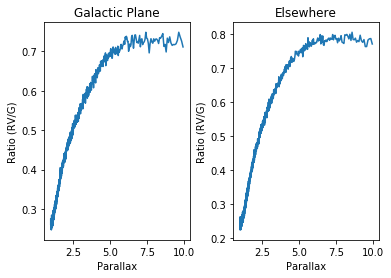

In [61]:
plt.subplot(1,2,1)
plt.plot(bins_centralized, ratio_galactic)
plt.xlabel('Parallax')
plt.ylabel('Ratio (RV/G)')
plt.title("Galactic Plane")

plt.subplot(1,2,2)
plt.plot(bins_centralized, ratio_elsewhere)
plt.xlabel('Parallax')
plt.ylabel('Ratio (RV/G)')
plt.title("Elsewhere")
plt.subplots_adjust(wspace = 0.3)

plt.savefig("Comparison of Parallax Selection of Galactic Plane vs E")